In [ ]:
import os
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt


class S8(object):
    def __init__(self, binsize: int = 1):
        self.binsize = binsize  # will be set to 1 - current data only has a binsize of 10

    def __get_absolute_path(self, input_path):
        return os.path.abspath(os.path.expanduser(input_path))

    def vcf_to_dataframe(self, path):
        vcf_path = self.__get_absolute_path(path)
        vcf_file = open(vcf_path, "r") if "gz" not in vcf_path else gzip.open(vcf_path, "rt")
        line_cnt = 0
        header_cnt = 0

        result = []

        for line in vcf_file:
            if line.__contains__("#"):
                header_cnt += 1
                continue
            cells = line.strip().split("\t")
            chrom_ = cells[0]
            start_ = int(cells[1])
            ref_ = cells[3]
            alt_ = cells[4]
            quality_ = float(cells[5])
            filter_ = cells[6]
            info_ = cells[7]
            format_ = cells[8]
            # sample_ = cells[9]
            # print(start_,cells)
            if not (ref_.__contains__(",") or alt_.__contains__(",")):
                varient_type = ""
                ins_adjust = 0
                ref_alt_len = len(ref_) - len(alt_)
                if ref_alt_len == 0:
                    varient_type = "SNV"
                elif ref_alt_len > 0:  # ref_ longer
                    varient_type = "DEL"
                elif ref_alt_len < 0:  # alt_ longer
                    varient_type = "INS"
                    ins_adjust = 1
                else:
                    print("error", line)
                    continue
                end_ = start_ + abs(ref_alt_len - ins_adjust) + 1
    
                result.append([chrom_, start_, end_, varient_type])
        return pd.DataFrame(data=result, columns=["chrom_", "start_", "end_", "var_type"])

    def get_coverage_for_variant(self, mosdepth_file: str = "", vcf_file: str = ""):

        df_vcf_all_chroms = self.vcf_to_dataframe(vcf_file)
        df_vcf_all_chroms_keys = df_vcf_all_chroms.chrom_.unique()

        mosdepth_file = self.__get_absolute_path(mosdepth_file)
        df_coverage_all = pd.read_csv(mosdepth_file, sep="\t", header=None, names=["chrom_", "start_", "end_", "cov_"])
        df_coverage_all_chroms_keys = df_coverage_all.chrom_.unique()

        for vcf_chrom_key in df_vcf_all_chroms_keys:
            # get subset for chrom in vcf
            df_vcf = df_vcf_all_chroms.loc[df_vcf_all_chroms.chrom_ == vcf_chrom_key]

            # check if vcf chrom key exists in mosdepth (coverage) file
            if vcf_chrom_key in df_coverage_all_chroms_keys:
                df_coverage = df_coverage_all.loc[df_coverage_all.chrom_ == vcf_chrom_key]

                # TODO group by chrom
                # TODO set binsize to given value
                self.cov_list = df_coverage.cov_.tolist()  # use list instead of pandas row, index = index/binsize
                self.cnt = 0

                df_vcf["distance_"] = df_vcf.apply(lambda row: int(abs(row["end_"] - row["start_"]) / self.binsize) + 1,
                                                   axis=1)
                df_vcf["coverage_"] = df_vcf.apply(lambda row: self.get_mean(row["start_"], row["distance_"]), axis=1)
                df_vcf["bingroup_"] = df_vcf.apply(lambda row: int(((row["distance_"] - 1) / 10) + 1) * 10,
                                                   axis=1)  # calculate bp bin groups, 1-10=10, 11-20=20, ...
        return df_vcf


    def get_mean(self, start, distance):
        s = int(start / self.binsize)
        x = self.cov_list[s:s + distance]
        tmp = np.mean(x)
        self.cnt += 1
        if np.isnan(tmp):
            return 0.0
        return tmp


In [2]:

df = pd.DataFrame(data=[], columns=["a"])
x = df.a.mean()

s8 = S8()


In [5]:
folder = "/Volumes/work/FritzLab/GIAB_project/nist-grex/S8-variant-coverage/data"
df_vcf_chr22 = s8.get_coverage_for_variant(mosdepth_file=folder+"/coverage_1bp_chr22.regions.bed",
                            vcf_file=folder+"/HG002.hiseqx.grch38_chr22.vcf")

In [13]:

cov_all_chr22 ={}
for sv_type in df_vcf_chr22.var_type.unique():
    df_data = df_vcf_chr22.loc[df_vcf_chr22.var_type == sv_type]
    df_subset = df_data[["coverage_", "bingroup_"]]
    df_grouped = df_subset.groupby("bingroup_")
    df_mean = df_grouped.mean()
    
    cov_all_chr22[sv_type] ={}
    cov_list= list(df_mean['coverage_'].values)
    bin_list= list(df_mean.index)
    for i, bin_ in enumerate(bin_list):
        cov_all_chr22[sv_type][bin_]= cov_list[i]
cov_max =0
for svtype, cov_ in cov_all_chr22.items():
    cov_max = max(cov_max,max(cov_.keys()))
print(cov_max)


cov_max=200
bingroups = list(range(10,cov_max+1,10))

cov_all_full_chr22 ={}
for svtype, cov_ in cov_all_chr22.items():
    cov_all_full_chr22[svtype] = [0]*int(cov_max/10+1)
    rest=[]
    for bin_, cov_val in cov_.items():
        if bin_ < cov_max+1:
            cov_all_full_chr22[svtype][int(bin_/10) -1] = cov_val
        else:
            rest.append(cov_val)
        if rest:
            cov_all_full_chr22[svtype][-1] = np.mean(rest)
            
cov_all_full_chr22

340

In [15]:
folder = "/Volumes/work/FritzLab/GIAB_project/nist-grex/S8-variant-coverage/data"
df_vcf_chr1 = s8.get_coverage_for_variant(mosdepth_file=folder+"/coverage_1bp_chr1.regions.bed",
                            vcf_file=folder+"/HG002.hiseqx.grch38_chr1.vcf")

In [16]:

cov_all_chr1 ={}
for sv_type in df_vcf_chr1.var_type.unique():
    df_data = df_vcf_chr1.loc[df_vcf_chr1.var_type == sv_type]
    df_subset = df_data[["coverage_", "bingroup_"]]
    df_grouped = df_subset.groupby("bingroup_")
    df_mean = df_grouped.mean()
    
    cov_all_chr1[sv_type] ={}
    cov_list= list(df_mean['coverage_'].values)
    bin_list= list(df_mean.index)
    for i, bin_ in enumerate(bin_list):
        cov_all_chr1[sv_type][bin_]= cov_list[i]

cov_max =0
for svtype, cov_ in cov_all_chr1.items():
    cov_max = max(cov_max,max(cov_.keys()))
print(cov_max)


cov_max=200
bingroups = list(range(10,cov_max+1,10))


340


NameError: name 'cov_all_full_chr2' is not defined

In [19]:

cov_all_full_chr1 ={}
for svtype, cov_ in cov_all_chr1.items():
    cov_all_full_chr1[svtype] = [0]*int(cov_max/10+1)
    rest=[]
    for bin_, cov_val in cov_.items():
        if bin_ < cov_max+1:
            cov_all_full_chr1[svtype][int(bin_/10) -1] = cov_val
        else:
            rest.append(cov_val)
        if rest:
            cov_all_full_chr1[svtype][-1] = np.mean(rest)
            
cov_all_full_chr1

{'INS': [42.37170479333731,
  42.36500137914503,
  43.84197390361908,
  42.117247285400765,
  48.73898085467381,
  53.28645908782269,
  55.467653688103965,
  56.74959641310693,
  49.60005109763673,
  56.509897296763654,
  71.56481481481481,
  65.0695652173913,
  52.07692307692308,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'DEL': [38.28768109399349,
  37.90614260122728,
  46.78894847948625,
  29.487242731914172,
  34.187536222468275,
  24.613290405430558,
  26.58311436534819,
  30.819272094963967,
  28.520687357432084,
  25.674938008167587,
  24.89055993556346,
  30.941585760234535,
  24.216966794314764,
  43.16668152575755,
  38.090230816428345,
  32.257232030554505,
  36.97907217293094,
  33.12529862630889,
  36.884126533041055,
  31.364656982077744,
  31.726137569099592],
 'SNV': [42.85930000996774,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

<Figure size 1080x864 with 0 Axes>

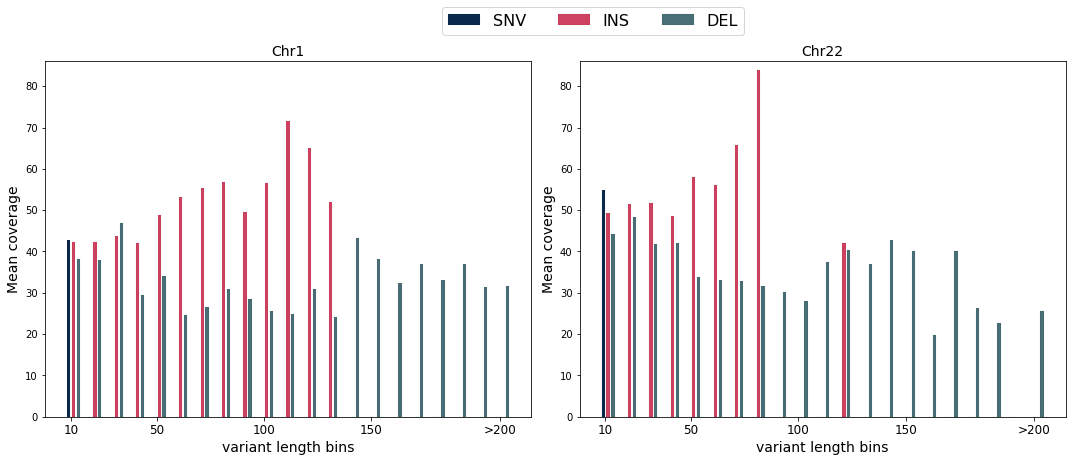

In [26]:
bingroups_ = bingroups + [210]
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,12))

fig, axs = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(6)
fig.set_figwidth(15)
# ind = np.arange(0,12,2)

#fig.suptitle('Vertically stacked subplots')
axs[0].bar([2*i-2 for i in bingroups_], cov_all_full_chr1['SNV'] , color = '#0A284B', width = 3, edgecolor = "black", linewidth=0.04)
axs[0].bar([2*i+2.5 for i in bingroups_], cov_all_full_chr1['INS'] , color = '#CF4160', width = 3, edgecolor = "black", linewidth=0.04)
axs[0].bar([2*i+7 for i in bingroups_], cov_all_full_chr1['DEL'], color = '#486E76', width = 3, edgecolor = "black", linewidth=0.04)

axs[0].set_xticks([i*2 for i in  [10,50,100,150,210]])
axs[0].set_xticklabels( [10,50,100,150,">200"], fontsize=12)
axs[0].set_xlabel("variant length bins", fontsize=14)
axs[0].set_ylabel("Mean coverage", fontsize=14)
axs[0].set_title("Chr1", fontsize=14)
#axs[0].set_xlim([2*i for i in [0.5,25]])
axs[0].set_ylim([0,86])


axs[1].bar([2*i-2 for i in bingroups_], cov_all_full_chr22['SNV'] , color = '#0A284B', width = 3, edgecolor = "black", linewidth=0.04)
axs[1].bar([2*i+2.5 for i in bingroups_], cov_all_full_chr22['INS'] , color = '#CF4160', width = 3, edgecolor = "black", linewidth=0.04)
axs[1].bar([2*i+7 for i in bingroups_], cov_all_full_chr22['DEL'], color = '#486E76', width = 3, edgecolor = "black", linewidth=0.04)

axs[1].set_xticks([i*2 for i in  [10,50,100,150,210]])
axs[1].set_xticklabels( [10,50,100,150,">200"], fontsize=12)
axs[1].set_xlabel("variant length bins", fontsize=14)
axs[1].set_ylabel("Mean coverage", fontsize=14)
axs[1].set_title("Chr22", fontsize=14)
#axs[0].set_xlim([2*i for i in [0.5,25]])
axs[1].set_ylim([0,86])

fig.legend(["SNV","INS","DEL"], loc='upper right', bbox_to_anchor=(0.7,1.08), ncol=3, fontsize=16)# , bbox_transform=fig.transFigure , bbox_to_anchor=(1,-0.1),

fig.tight_layout()

plt.savefig("fig_output/cov_v3_.tiff", bbox_inches='tight')

# old

In [ ]:
groups_dic_vals= {}

bingroup_all  =[]
sv_type_all =[]
cov_all ={}
for sv_type in df_vcf.var_type.unique():
    df_data = df_vcf.loc[df_vcf.var_type == sv_type]
    df_subset = df_data[["coverage_", "bingroup_"]]
    df_grouped = df_subset.groupby("bingroup_")
    df_mean = df_grouped.mean()
    
    cov_all[sv_type] ={}
    cov_list= list(df_mean['coverage_'].values)
    bin_list= list(df_mean.index)
    for i, bin_ in enumerate(bin_list):
        cov_all[sv_type][bin_]= cov_list[i]
        
    

In [ ]:
cov_max =0
for svtype, cov_ in cov_all.items():
    cov_max = max(cov_max,max(cov_.keys()))
cov_max  

In [ ]:
# bingroups = list(range(10,cov_max+1,10))

# cov_all_full ={}
# for svtype, cov_ in cov_all.items():
#     cov_all_full[svtype] =[0]*int(cov_max/10)
#     for bin_, cov_val in cov_.items():
#         cov_all_full[svtype][int(bin_/10) -1] = cov_val
        
    
# cov_all_full['SNV']  

    
    

In [ ]:
cov_all

In [ ]:
cov_max=200
bingroups = list(range(10,cov_max+1,10))

cov_all_full ={}
for svtype, cov_ in cov_all.items():
    cov_all_full[svtype] = [0]*int(cov_max/10+1)
    rest=[]
    for bin_, cov_val in cov_.items():
        if bin_ < cov_max+1:
            cov_all_full[svtype][int(bin_/10) -1] = cov_val
        else:
            rest.append(cov_val)
        if rest:
            cov_all_full[svtype][-1] = np.mean(rest)
            
            
            

    

    
    

In [ ]:
len(cov_all_full['SNV'])

In [ ]:
len([2*i+0 for i in bingroups])

In [ ]:
len([2*i+0 for i in bingroups]), len(cov_all_full['SNV'])

In [ ]:
bingroups_ = bingroups + [210]
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,12))

fig, axs = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(6)
fig.set_figwidth(15)
# ind = np.arange(0,12,2)

#fig.suptitle('Vertically stacked subplots')
axs[0].bar([2*i-2 for i in bingroups_], cov_all_full['SNV'] , color = '#0A284B', width = 3, edgecolor = "black", linewidth=0.04)
axs[0].bar([2*i+2.5 for i in bingroups_], cov_all_full['INS'] , color = '#CF4160', width = 3, edgecolor = "black", linewidth=0.04)
axs[0].bar([2*i+7 for i in bingroups_], cov_all_full['DEL'], color = '#486E76', width = 3, edgecolor = "black", linewidth=0.04)

axs[0].set_xticks([i*2 for i in  [10,50,100,150,210]])
axs[0].set_xticklabels( [10,50,100,150,">200"], fontsize=12)
axs[0].set_xlabel("variant length bins", fontsize=14)
axs[0].set_ylabel("Mean coverage", fontsize=14)
axs[0].set_title("Chr22", fontsize=14)
#axs[0].set_xlim([2*i for i in [0.5,25]])





axs[0].bar([2*i-2 for i in bingroups_], cov_all_full['SNV'] , color = '#0A284B', width = 3, edgecolor = "black", linewidth=0.04)
axs[0].bar([2*i+2.5 for i in bingroups_], cov_all_full['INS'] , color = '#CF4160', width = 3, edgecolor = "black", linewidth=0.04)
axs[0].bar([2*i+7 for i in bingroups_], cov_all_full['DEL'], color = '#486E76', width = 3, edgecolor = "black", linewidth=0.04)

axs[0].set_xticks([i*2 for i in  [10,50,100,150,210]])
axs[0].set_xticklabels( [10,50,100,150,">200"], fontsize=12)
axs[0].set_xlabel("variant length bins", fontsize=14)
axs[0].set_ylabel("Mean coverage", fontsize=14)
axs[0].set_title("Chr22", fontsize=14)
#axs[0].set_xlim([2*i for i in [0.5,25]])


fig.legend(["SNV","INS","DEL"], loc='upper right', bbox_to_anchor=(0.7,1.08), ncol=3, fontsize=16)# , bbox_transform=fig.transFigure , bbox_to_anchor=(1,-0.1),

fig.tight_layout()

plt.savefig("fig_output/cov_v2.png", bbox_inches='tight')

In [ ]:
bingroups

In [ ]:
for sv_type in df_vcf.var_type.unique():
    df_data = df_vcf.loc[df_vcf.var_type == sv_type]
    df_subset = df_data[["coverage_", "bingroup_"]]
    # plt.hist(data=df_subset,x="bingroup_")
    # plt.show()
    df_grouped = df_subset.groupby("bingroup_")
    df_mean = df_grouped.mean()
    df_mean.plot(kind="bar")
    
    
    
    
#    plt.title(f"{chr22 average mean {str(sv_type)}")
#     plt.xlabel("binsize")
#     plt.ylabel("mean coverage")
#     plt.savefig(f"./data/{vcf_chrom_key}_{sv_type}.png")

In [ ]:
axs[0].bar([2*i+0 for i in list(range(1,25))],   cds_length_37_list,                  color = '#0A284B', width = 0.3, edgecolor = "black", linewidth=0.1)
axs[0].bar([2*i+0.45 for i in list(range(1,25))],cds_length_38_list, color = '#CF4160', width = 0.3, edgecolor = "black", linewidth=0.1)
axs[0].bar([2*i+0.9 for i in list(range(1,25))], cds_length_t2t_list, color = '#486E76', width = 0.3, edgecolor = "black", linewidth=0.1)


In [ ]:
for sv_type in df_vcf.var_type.unique():
    #plt.title(f"chr22: average mean {str(sv_type)}")
    #plt.xlabel("binsize")
    #plt.ylabel("mean coverage")
    #plt.show()
    #plt.savefig(f"./data/{vcf_chrom_key}_{sv_type}.png")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#fig = plt.figure()

fig, axs = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(6)
fig.set_figwidth(15)
# ind = np.arange(0,12,2)

#fig.suptitle('Vertically stacked subplots')
axs[0].bar([2*i+0 for i in list(range(1,25))],   cds_length_37_list,                  color = '#0A284B', width = 0.3, edgecolor = "black", linewidth=0.1)
axs[0].bar([2*i+0.45 for i in list(range(1,25))],cds_length_38_list, color = '#CF4160', width = 0.3, edgecolor = "black", linewidth=0.1)
axs[0].bar([2*i+0.9 for i in list(range(1,25))], cds_length_t2t_list, color = '#486E76', width = 0.3, edgecolor = "black", linewidth=0.1)


axs[0].set_xticks([i*2 for i in  [1,5,10,15,20,22,23,24]])
axs[0].set_xticklabels( [1,5,10,15,20,22,"X","Y"], fontsize=14)
axs[0].set_xlabel("Chromsome", fontsize=14)
axs[0].set_ylabel("CDS length", fontsize=14)
axs[0].set_xlim([2*i for i in [0.5,25]])


axs[1].bar([2*i+0 for i in list(range(1,25))],   cds_ratio_37,                  color = '#0A284B', width = 0.3, edgecolor = "black", linewidth=0.1)
axs[1].bar([2*i+0.45 for i in list(range(1,25))],cds_ratio_38, color = '#CF4160', width = 0.3, edgecolor = "black", linewidth=0.1)
axs[1].bar([2*i+0.9 for i in list(range(1,25))], cds_ratio_t2t, color = '#486E76', width = 0.3, edgecolor = "black", linewidth=0.1)

axs[1].set_xticks([i*2 for i in  [1,5,10,15,20,22,23,24]])
axs[1].set_xticklabels( [1,5,10,15,20,22,"X","Y"], fontsize=14)
axs[1].set_xlabel("Chromsome", fontsize=14)
axs[1].set_ylabel("CDS length/ chromosome length (%)", fontsize=14)
axs[1].set_xlim([2*i for i in [0.5,25]])
